In [1]:
!mv ../data/modules/regsubset.py .

# 6.5 Lab: Linear Models and Regularization Methods

**First**: Read Chapter 6.1, 6.2.

This lab has the following sections:
* Best Subset Selection Methods
* Forward and Backward Stepwise Selection
* Choosing Among Models Using The Validation-Set Approach and Cross-Validation
* Ridge Regression
* The Lasso Regression

In [35]:
# These are added for the regsubset implementation
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from regsubset import OLS, exhaustive_search, forward_search, backward_search
from sklearn.metrics import mean_squared_error
from statsmodels.api import add_constant

## 6.5.1 Subset Selection Methods
### Best Subset Selection
Here we apply the best subset selection approach to the `Hitters` data.
We wish to predict a baseball player's `Salary` on the basis of various statistics associated with performance in the previous year. First, let's load the data:

In [52]:
Hitters = pd.read_csv('../data/islr_data/Hitters.csv')
Hitters.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,NaN,A
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N


You can see above that the `Salary` variable is missing for some of the players.  The `isna()` function can be used to identify the missing observations. It returns a vector of the same length as the input vector, with a `True` for any elements that are missing, and a `False` for non-missing elements. The `sum()` function can then be used to count all of the missing elements.

In [53]:
print("Shape: ", Hitters.shape)
print("Nr of NA values in `Salary`:", sum(pd.isna(Hitters['Salary'])))

Shape:  (322, 20)
Nr of NA values in `Salary`: 59


Hence we see that `Salary` is missing for $59$ players. The `.dropna()` function removes all of the rows that have missing values in any variable.

In [54]:
Hitters = Hitters.dropna()
print("Shape: ", Hitters.shape)
print("Nr of na values in `Salary`:", Hitters["Salary"].isnull().sum())

Shape:  (263, 20)
Nr of na values in `Salary`: 0


Next, we remove the names and convert the three categorical variables to dummies, binary variables indicating each category (1-0 or 0-1). As these variables are binary, we actually can make do with one dummy variable (1 or 0). Finally, we split the data into the predictors (X) and the response (y).

In [55]:
# We need to convert our categorical predicors into dummies
Hitters = pd.get_dummies(Hitters, columns=['League', 'Division', 'NewLeague']).astype(int)

**Exercise:**
  - Check Hitters dataframe, which columns were added after using the get_dummies function?

In [56]:
#ToDo
Hitters.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,...,PutOuts,Assists,Errors,Salary,League_A,League_N,Division_E,Division_W,NewLeague_A,NewLeague_N
1,315,81,7,24,38,39,14,3449,835,69,...,632,43,10,475,0,1,0,1,0,1
2,479,130,18,66,72,76,3,1624,457,63,...,880,82,14,480,1,0,0,1,1,0
3,496,141,20,65,78,37,11,5628,1575,225,...,200,11,3,500,0,1,1,0,0,1
4,321,87,10,39,42,30,2,396,101,12,...,805,40,4,91,0,1,1,0,0,1
5,594,169,4,74,51,35,11,4408,1133,19,...,282,421,25,750,1,0,0,1,1,0


In [57]:
# Each categorical feature only has two categories, so we can delete the second column for every dummy
Hitters = Hitters.drop('League_A', axis=1).drop('Division_E', axis=1).drop('NewLeague_A', axis=1)

y = Hitters['Salary']              # We want to predict `Salary` with all other predictors
X = Hitters.drop('Salary', axis=1) # We want to use all predictors except `Salary`, of course
X = add_constant(X)

The book uses an R function `regsubsets()` which performs subset selection for linear regression. An identical function is not available in Python, so we provide some pre-made code in the accompanying `regsubset.py` module ourselves. At the end of this block we will also show how you can work with subset selection in scikit-learn.

`exhaustive_search()` performs best subset selection by identifying the best model that contains a given number of predictors, where *best* is quantified using RSS. If you want, you can have a look at the code in the `regsubset.py` module; you may use it to learn how things are implemented, but do not worry if you do not immediately understand things, as you will later use pre-defined functions. Note that `regsubset.py` provides a function OLS, which is a wrapper for the same function in `statsmodels`, adapted for feature subset selection.

We first instantiate our model wrapper from the regsubset module. `fit_intercept = True` means that we want to also fit an intercept.

In [59]:
lm = OLS(fit_intercept=True)

Then we can supply wrapped model to our subset search function. The `nvmax` parameter determines the maximum size of our feature subset. For example, `nvmax = 4` means that the search function will look for the best model with 1 feature, the best model with 2 features, the best model with 3 features, and the best model with 4 features. Let's try to go up to 4 features:

**Exercise**
 - Add the missing parameter and try with 4 and 7 features.

In [195]:
print(y)

1       475
2       480
3       500
4        91
5       750
       ... 
317     700
318     875
319     385
320     960
321    1000
Name: Salary, Length: 263, dtype: int64


In [193]:
#ToDo
lm_exhaustive = exhaustive_search(lm, X, y, nvmax = 10)

calculating scores for 'nfeat=1'...
calculating scores for 'nfeat=2'...
calculating scores for 'nfeat=3'...
calculating scores for 'nfeat=4'...
calculating scores for 'nfeat=5'...


KeyboardInterrupt: 

With the `exhaustive_search()` function we have found the best models trained with 1 feature up to 7 features (all with an intercept); if you are brave, you can try increasing `nvmax`, but beware the time needed will increase quickly.

Have a look at which features were picked by the algorithm. What do you notice?

**Exercise**
 - Have a look at which features were picked by the algorithm. What do you notice? Hint: You can get the models with lm_exhaustive.models, for each model you can use model.coefs() function which returns two values: name (variable) and coef.

The method also stores the metrics for each best subset model, which match those in ISLR (note that $C_p$ and $AIC$ are proportional for least squares regression), in a dictionary `metrics`. Below, we convert this to a dataframe only for ease of printing:

In [82]:
pd.DataFrame.from_dict(lm_exhaustive.metrics)

,n,rss,aic,bic,rsquared,rsquared_adj
0,1,3.617845e+07,3862.130370,3869.274678,0.321412,0.318812
1,2,3.064475e+07,3820.471805,3831.188267,0.425206,0.420784
2,3,2.924747e+07,3810.197973,3824.486589,0.451414,0.445060
3,4,2.796970e+07,3800.449500,3818.310270,0.475381,0.467247
4,5,2.714857e+07,3794.612737,3816.045662,0.490782,0.480876
5,6,2.619324e+07,3787.191299,3812.196377,0.508701,0.497186
6,7,2.590530e+07,3786.284146,3814.861378,0.514102,0.500764
7,8,2.513579e+07,3780.353436,3812.502823,0.528536,0.513686
8,9,2.481303e+07,3778.954430,3814.675971,0.534590,0.518033
9,10,2.449935e+07,3777.608491,3816.902186,0.540473,0.522238


The exhaustive search function outputs a `Result` object. This `Result` object has a method `best_model()` for returning the best model based on a given metric. Here we want to know what the best model is (i.e., what the best feature subset is) based on $R_2^{adjusted}$. The best model has the highest $R_2^{adjusted}$. How many features are optimal?

In [ ]:
lm_exhaustive.best_model(metric='rsquared_adj', best=max)

We can also select a specific other model included in the results, for example the best model trained on a subset of a certain number of features, by specifying the parameter `n`.

**Exercise**
 - Use the code to select the model with 6 features.

In [83]:
#ToDo
lm_exhaustive.get_model(n=6)

OLS Regression Results                            
==============================================================================
Dep. Variable:                 Salary   R-squared:                       0.509
Model:                            OLS   Adj. R-squared:                  0.497
Method:                 Least Squares   F-statistic:                     44.18
Date:                Tue, 20 Feb 2024   Prob (F-statistic):           6.84e-37
Time:                        21:14:47   Log-Likelihood:                -1886.6
No. Observations:                 263   AIC:                             3787.
Df Residuals:                     256   BIC:                             3812.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     91.4334     64.998      1.407      0.161     -36.565     219.432
AtBat         -1.8688      0.527     -3.543      0.000      -2.907      -0.830
Hits           7.6052      1.662      4.575      0.000       4.331      10.879
Walks          3.6983      1.210      3.056      0.002       1.315       6.082
CRBI           0.6429      0.064      9.978      0.000       0.516       0.770
PutOuts        0.2643      0.075      3.535      0.000       0.117       0.412
Division_W  -122.9118     39.819     -3.087      0.002    -201.326     -44.497
==============================================================================
Omnibus:                      101.297   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              614.753
Skew:                           1.411   Prob(JB):                    3.22e-134
Kurtosis:                       9.938   Cond. No.                     2.29e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.29e+03. This might indicate that there are
strong multicollinearity or other numerical problems.

We can also visualize the metrics calculated to facilitate choosing an optimal subset, as follows. According to which metric is a subset of 6 features optimal?

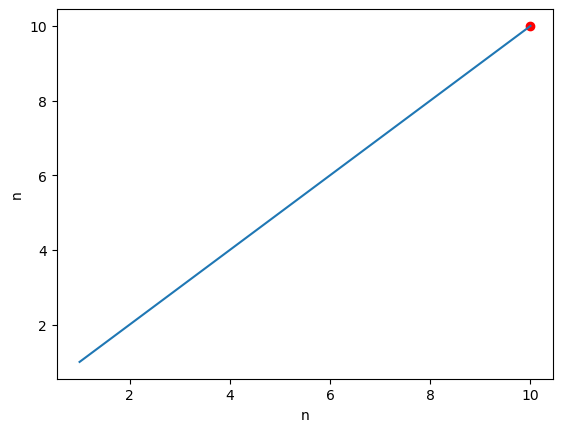

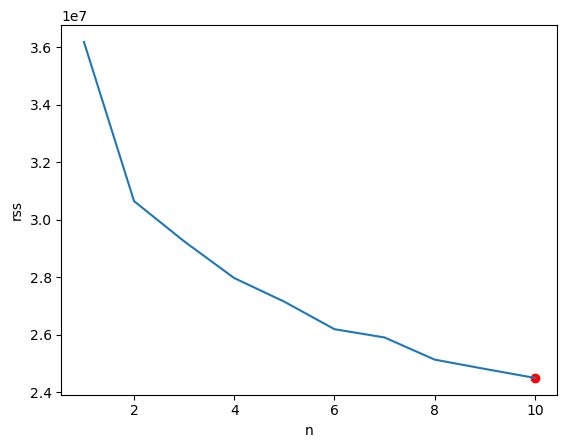

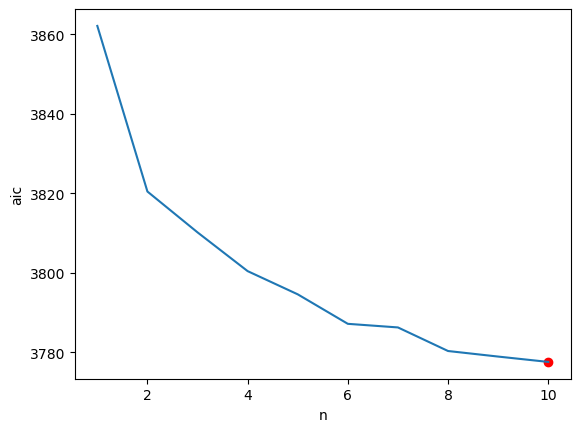

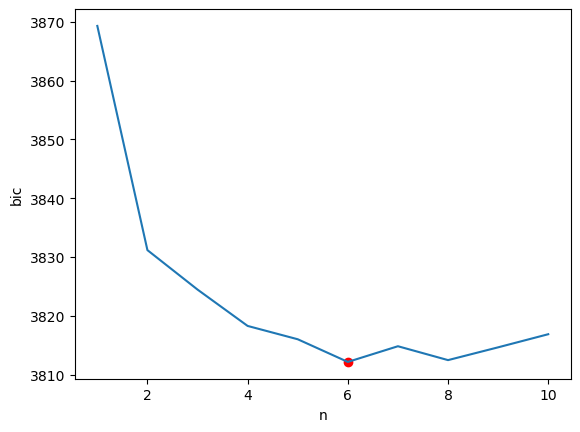

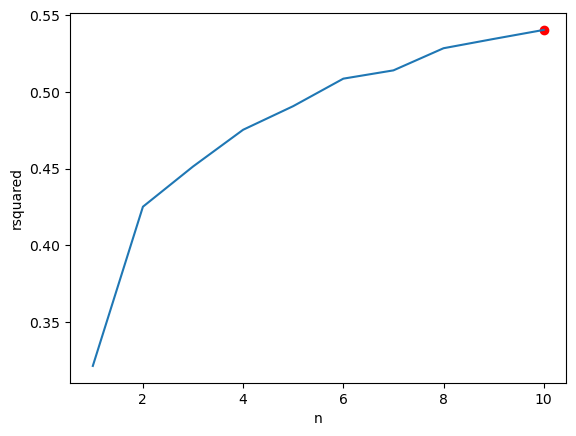

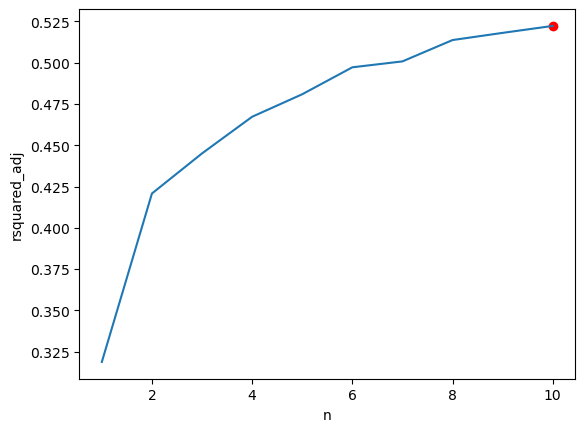

In [84]:
lm_exhaustive.plot()

### Forward and Backward Stepwise Selection
Next to exhaustive search, we can also use the `forward_search()` for forward search and `backward_search()` for backward search. Instead of `nvmax`, `backward_search()` takes in `nvmin`, since the search for best subset per feature subset size is backwards.

For instance, we see that using forward stepwise selection, the best one-variable model contains only `CRBI`, and the best two-variable model additionally includes `Hits`:


In [85]:
lm = OLS(fit_intercept=True)
lm_forward = forward_search(lm, X, y, nvmax=19)

**Exercise**
- Obtain the best models for 1 and 2 features using forward search.

In [86]:
#ToDo
lm_forward.get_model(n=1)

OLS Regression Results                            
==============================================================================
Dep. Variable:                 Salary   R-squared:                       0.321
Model:                            OLS   Adj. R-squared:                  0.319
Method:                 Least Squares   F-statistic:                     123.6
Date:                Tue, 20 Feb 2024   Prob (F-statistic):           9.14e-24
Time:                        21:37:12   Log-Likelihood:                -1929.1
No. Observations:                 263   AIC:                             3862.
Df Residuals:                     261   BIC:                             3869.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    274.5336     32.855      8.356      0.000     209.839     339.228
CRBI           0.7909      0.071     11.119      0.000       0.651       0.931
==============================================================================
Omnibus:                       85.154   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              284.275
Skew:                           1.370   Prob(JB):                     1.86e-62
Kurtosis:                       7.294   Cond. No.                         661.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.

In [87]:
#ToDo
lm_forward.get_model(n=2)

OLS Regression Results                            
==============================================================================
Dep. Variable:                 Salary   R-squared:                       0.425
Model:                            OLS   Adj. R-squared:                  0.421
Method:                 Least Squares   F-statistic:                     96.17
Date:                Tue, 20 Feb 2024   Prob (F-statistic):           5.45e-32
Time:                        21:37:18   Log-Likelihood:                -1907.2
No. Observations:                 263   AIC:                             3820.
Df Residuals:                     260   BIC:                             3831.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    -48.0195     55.981     -0.858      0.392    -158.253      62.214
CRBI           0.6898      0.067     10.261      0.000       0.557       0.822
Hits           3.3010      0.482      6.852      0.000       2.352       4.250
==============================================================================
Omnibus:                      117.656   Durbin-Watson:                   1.927
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              700.531
Skew:                           1.703   Prob(JB):                    7.62e-153
Kurtosis:                      10.233   Cond. No.                     1.24e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.24e+03. This might indicate that there are
strong multicollinearity or other numerical problems.

Did you notice how much faster forward search is than exhaustive search?

For this data, the best one-variable through six-variable models are each identical for best subset and forward selection.

**Exercise**
 - Print the best variables for models 1 to 6. You can get the models with lm_forward.models, for each model you can use model.coefs() function which returns two values: name (variable) and coef.

In [104]:
#ToDo
for x in range(1,7):
    tp = lm_forward.models[x].coefs()
    print(*tp, "\n")

('intercept', -48.01947480966312) ('CRBI', 0.6898112023138956) ('Hits', 3.301016551848229) 

('intercept', -71.52300624179068) ('CRBI', 0.6824392702880209) ('Hits', 2.803983653160868) ('PutOuts', 0.2735839181968026) 

('intercept', 13.836492834684863) ('CRBI', 0.681690933594913) ('Hits', 2.675999488968113) ('PutOuts', 0.2735027249220796) ('Division_W', -139.91647083531169) 

('intercept', 97.69110935236874) ('CRBI', 0.6881205405258657) ('Hits', 7.176020964144347) ('PutOuts', 0.2905208283147912) ('Division_W', -129.69338902897226) ('AtBat', -1.4403026817962075) 

('intercept', 91.43340488921429) ('CRBI', 0.6429217008845945) ('Hits', 7.605173729568927) ('PutOuts', 0.26430742907683047) ('Division_W', -122.91180184769179) ('AtBat', -1.8688238401573387) ('Walks', 3.698291545038986) 

('intercept', 109.68646174844496) ('CRBI', 0.853408076563397) ('Hits', 7.450843143462169) ('PutOuts', 0.2533537278175098) ('Division_W', -127.07753699716903) ('AtBat', -1.9590088044337741) ('Walks', 4.912291643

However, the best seven-variable models identified by forward stepwise selection, backward stepwise selection, and best subset selection are different:

In [105]:
lm_exhaustive.get_model(n=7).coefs()

[('intercept', 79.34405552563494),
 ('Hits', 1.2834465791925591),
 ('Walks', 3.2280044946173234),
 ('CAtBat', -0.37519038791538956),
 ('CHits', 1.4955598918671005),
 ('CHmRun', 1.4415801677040518),
 ('PutOuts', 0.23668320859243808),
 ('Division_W', -129.94979963154464)]

In [106]:
lm_forward.get_model(n=7).coefs()

[('intercept', 109.68646174844496),
 ('CRBI', 0.853408076563397),
 ('Hits', 7.450843143462169),
 ('PutOuts', 0.2533537278175098),
 ('Division_W', -127.07753699716903),
 ('AtBat', -1.9590088044337741),
 ('Walks', 4.9122916431476895),
 ('CWalks', -0.30493193404006014)]

In [107]:
lm = OLS(fit_intercept=True)
lm_backward = backward_search(lm, X, y, nvmin=1)
lm_backward.get_model(n=7).coefs()

[('intercept', 105.55461079888008),
 ('AtBat', -1.9764384125903505),
 ('Hits', 6.758560392404973),
 ('Walks', 6.055154913415393),
 ('CRuns', 1.12899315364458),
 ('CWalks', -0.715980960212473),
 ('PutOuts', 0.30287922131230993),
 ('Division_W', -116.12937589576565)]

### Choosing Among Models Using the Validation-Set Approach and Cross-Validation
We just saw that it is possible to choose among a set of models of different sizes using Mallow's $C_{p}$, $BIC$, and $R^{2}_{adjusted}$. We will now consider how to do this using the validation set and cross-validation approaches.

In order for these approaches to yield accurate estimates of the test error, we must use *only the training observations* to perform all aspects of model-fitting - including variable selection. Therefore, the determination of which model of a given size is best must be made using *only the training observations*. This point is subtle but important. If the full data set is used to perform the best subset selection step, the validation set errors and cross-validation errors that we obtain will not be accurate estimates of the test error.

To use the validation set approach, we begin by splitting the observations into a training set and a test set:

In [110]:
np.random.seed(42)
mask = np.random.rand(len(Hitters)) < 0.5
train = Hitters[mask]
val = Hitters[~mask]
print(mask.shape, train.shape, val.shape)

(263,) (130, 20) (133, 20)


Now we apply `forward_search()` on the training set in order to perform best subset selection:

In [111]:
X_train = train.drop('Salary', axis=1)
y_train = train['Salary']

lm = OLS(fit_intercept=True)
lm_val = forward_search(lm, X_train, y_train, nvmax=18)

We can then use a small for-loop to calculate the error on the test set with each model.

**Exercise**
 - In the following block of code, compute the $val\_error$ (Mean Squared Error (MSE)).

In [113]:
X_val = val.drop('Salary', axis=1)
y_val = val['Salary']

val_errors = []
for n in lm_val.ns:
    model = lm_val.models[n - 1]
    subset = lm_val.subsets[n - 1]
    y_pred = model.predict(X_val, subset)
    val_error = mean_squared_error(y_val, y_pred)
    val_errors.append(val_error)

In [114]:
for i, val_error in enumerate(val_errors): print(i + 1, val_error)

1 194489.60489571368
2 172779.67217524518
3 173200.6143119054
4 167749.6164506029
5 162446.1851082343
6 158203.30533069122
7 156276.12389815564
8 152694.98963157844
9 153273.54727887997
10 162312.065886414
11 161458.81162290167
12 161314.7151320735
13 161653.32216633443
14 161960.04315948152
15 161390.5063581238
16 161572.79625662294
17 162069.76177144307
18 162206.82226388346


([<matplotlib.axis.XTick at 0x7f98bfa8c250>,
 [Text(0, 0, '0'),
  Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9'),
  Text(10, 0, '10'),
  Text(11, 0, '11'),
  Text(12, 0, '12'),
  Text(13, 0, '13'),
  Text(14, 0, '14'),
  Text(15, 0, '15'),
  Text(16, 0, '16'),
  Text(17, 0, '17'),
  Text(18, 0, '18')])

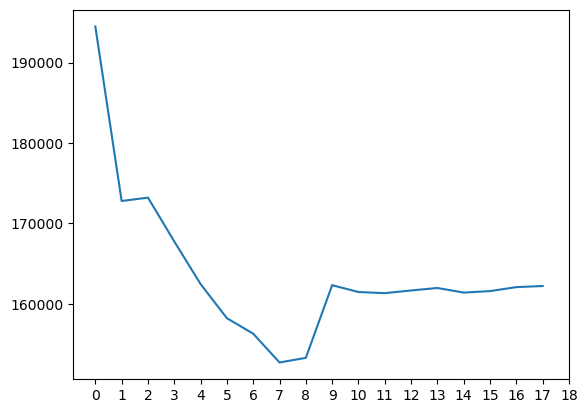

In [128]:
plt.plot(val_errors)
plt.xticks(np.arange(0, 19, step = 1))

In [129]:
best = val_errors.index(min(val_errors))
lm_val.get_model(best + 1)  # +1 since index 0 contains score for model with 1 feature

OLS Regression Results                            
==============================================================================
Dep. Variable:                 Salary   R-squared:                       0.687
Model:                            OLS   Adj. R-squared:                  0.666
Method:                 Least Squares   F-statistic:                     33.13
Date:                Tue, 20 Feb 2024   Prob (F-statistic):           4.41e-27
Time:                        21:50:16   Log-Likelihood:                -880.88
No. Observations:                 130   AIC:                             1780.
Df Residuals:                     121   BIC:                             1806.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     15.8953     67.785      0.234      0.815    -118.304     150.094
CRBI           0.7273      0.216      3.363      0.001       0.299       1.156
Hits           6.1932      1.656      3.740      0.000       2.915       9.472
PutOuts        0.3824      0.083      4.612      0.000       0.218       0.547
AtBat         -1.5299      0.540     -2.831      0.005      -2.600      -0.460
Division_W   -74.9253     40.130     -1.867      0.064    -154.373       4.522
Walks          4.0459      1.605      2.522      0.013       0.869       7.223
CWalks        -0.5430      0.269     -2.018      0.046      -1.076      -0.010
CRuns          0.3939      0.264      1.492      0.138      -0.129       0.917
==============================================================================
Omnibus:                        2.978   Durbin-Watson:                   2.306
Prob(Omnibus):                  0.226   Jarque-Bera (JB):                2.436
Skew:                           0.269   Prob(JB):                        0.296
Kurtosis:                       3.401   Cond. No.                     2.99e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.99e+03. This might indicate that there are
strong multicollinearity or other numerical problems.

According to the validation-set approach combined with forward-search, a 5-10 feature model is optimal.

**Exercise**
 - Note that this result depends on the particular train/validation set split. Try changing the random seed above to see how stable this result is.

Finally, to get good estimates of the coefficients, you should perform best subset selection on the full data set, and select the best model. It is important that we make use of the full dataset in order to obtain more accurate coefficient estimates. Note that we perform best subset selection on the full dataset and select the best model with the number of variables just found as optimal, rather than simply using the variables that were obtained from the training set, because the best variable subset model on the full data set may differ from the corresponding model on the training set.

In [130]:
lm = OLS(fit_intercept=True)
lm_full = exhaustive_search(lm, X=Hitters.drop('Salary', axis=1), y=Hitters['Salary'], nvmax=best)
lm_full.get_model(n=best).coefs()

calculating scores for 'nfeat=1'...
calculating scores for 'nfeat=2'...
calculating scores for 'nfeat=3'...
calculating scores for 'nfeat=4'...
calculating scores for 'nfeat=5'...
calculating scores for 'nfeat=6'...
calculating scores for 'nfeat=7'...
done


[('intercept', 79.34405552563494),
 ('Hits', 1.2834465791925591),
 ('Walks', 3.2280044946173234),
 ('CAtBat', -0.37519038791538956),
 ('CHits', 1.4955598918671005),
 ('CHmRun', 1.4415801677040518),
 ('PutOuts', 0.23668320859243808),
 ('Division_W', -129.94979963154464)]

In fact, we see that the best variable subset model on the full data set has a different set of variables than the best 7-variable model on the training set.

We will now try to choose among the models of different sizes using cross-validation. This approach is somewhat involved, as we must perform selection (here, forward selection) *within each of the k training sets*. We write a for-loop that performs cross-validation. In the *j*th fold, the elements of `kfolds` that equal `i` are in the test set, and the remainder are in the training set. We make our predictions for each model size and compute the test errors on the appropriate subset.  

In [161]:
def cross_val(data,labels,kfolds=10):
    data = data.to_numpy()
    labels = labels.to_numpy()

    folds = np.array_split(range(len(data)), kfolds)
    val_errors = {} # Dictionary: k CV errors for each number of features 1..19

    for i, fold in enumerate(folds):
        X_train = data[np.concatenate([fold for j, fold in enumerate(folds) if j != i])]
        y_train = labels[np.concatenate([fold for j, fold in enumerate(folds) if j != i])]
        X_val = data[folds[i]]
        y_val = labels[folds[i]]

        lm = OLS(fit_intercept=True)
        lm_cv = forward_search(lm, X_train, y_train, nvmax=19)

        for n in lm_cv.ns:
            model = lm_cv.models[n - 1]
            subset = lm_cv.subsets[n - 1]
            y_pred = model.predict(X_val, subset)
            val_error = mean_squared_error(y_val,y_pred) #((y_val - y_pred) ** 2).mean()
            # Add to dictionary
            if n-1 in val_errors:
                val_errors[n-1].append(val_error)
            else:
                val_errors[n-1] = [val_error]

    return val_errors

**Exercise**
 - Run a 10-fold cross-validation using the cross_val function defined above and store the results in $val\_errors$ variable.

In [162]:
#ToDo
val_errors = cross_val(Hitters, Hitters["Salary"])

In [171]:
df = pd.DataFrame(val_errors).transpose()

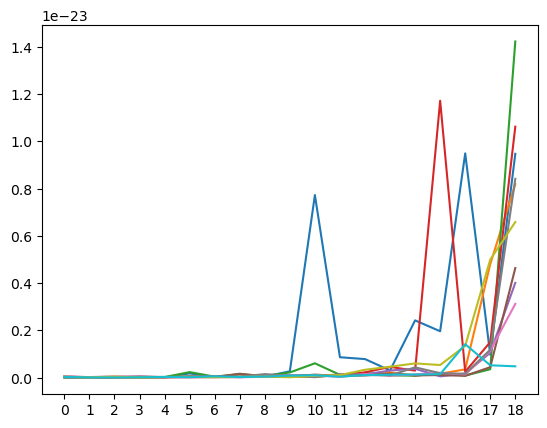

In [184]:
for n, x in df.items():
    plt.plot(x)
    plt.xticks(np.arange(0, 19, step = 1))

In [185]:
# Calculate average error over all folds for each number of features
errors = [sum(errors) / len(errors) for nfeat, errors in val_errors.items()]

# Find number of features with lowest average CV error
best = errors.index(min(errors)) + 1  # +1 since index 0 contains score for model with 1 feature

print(best)

2


We see that cross-validation selects an 8-variable model. We now perform forward selection
on the full data set in order to obtain the 8-variable model. The cross validation results are a lot more representative than those of the single train/validation split:

In [186]:
lm = OLS(fit_intercept=True)
lm_forward = forward_search(lm, Hitters.drop('Salary', axis=1), Hitters['Salary'], nvmax=19)
lm_forward.get_model(n=best)

OLS Regression Results                            
==============================================================================
Dep. Variable:                 Salary   R-squared:                       0.425
Model:                            OLS   Adj. R-squared:                  0.421
Method:                 Least Squares   F-statistic:                     96.17
Date:                Tue, 20 Feb 2024   Prob (F-statistic):           5.45e-32
Time:                        22:10:08   Log-Likelihood:                -1907.2
No. Observations:                 263   AIC:                             3820.
Df Residuals:                     260   BIC:                             3831.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    -48.0195     55.981     -0.858      0.392    -158.253      62.214
CRBI           0.6898      0.067     10.261      0.000       0.557       0.822
Hits           3.3010      0.482      6.852      0.000       2.352       4.250
==============================================================================
Omnibus:                      117.656   Durbin-Watson:                   1.927
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              700.531
Skew:                           1.703   Prob(JB):                    7.62e-153
Kurtosis:                      10.233   Cond. No.                     1.24e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.24e+03. This might indicate that there are
strong multicollinearity or other numerical problems.

### Subset selection in scikit-**learn**

Above, you have worked with custom code that connects well to the ISLR explanation of subset selection. The scikit-learn package that we often use has a built-in feature selection method, which is less flexible but is easier to use with more complex classifiers later. Here is an example, using forward or backward best subset selection with 10-fold cross-validation to find 7 features:

In [187]:
from sklearn import linear_model
from sklearn.feature_selection import SequentialFeatureSelector

reg_model = linear_model.LinearRegression()

forward_sfs = SequentialFeatureSelector(reg_model,
                                        n_features_to_select=7,
                                        direction='forward',
                                        scoring='neg_mean_squared_error',
                                        cv=10).fit(X,y)

backward_sfs = SequentialFeatureSelector(reg_model,
                                         n_features_to_select=7,
                                         direction='backward',
                                         scoring='neg_mean_squared_error',
                                         cv=10).fit(X,y)

print("Forward selection", forward_sfs.get_feature_names_out())
print("Backward selection", backward_sfs.get_feature_names_out())

Forward selection ['const' 'AtBat' 'Hits' 'Walks' 'CRBI' 'PutOuts' 'Division_W']
Backward selection ['AtBat' 'Hits' 'Walks' 'CRuns' 'CRBI' 'PutOuts' 'Division_W']


Note that due to the cross-validation, you may get different results here than using the code above. To obtain a dataset that contains just the selected features, you can use the `get_support()` or `transform()` functions:

In [188]:
print(X.shape)

X1 = X.loc[:,forward_sfs.get_support()]   # get_support() returns a boolean array, True for selected features
X2 = forward_sfs.transform(X)             # applies subset selection directly, returns a NumPy Array

print(X1.head())
print(X2[0:5,:])

(263, 20)
   const  AtBat  Hits  Walks  CRBI  PutOuts  Division_W
1    1.0    315    81     39   414      632           1
2    1.0    479   130     76   266      880           1
3    1.0    496   141     37   838      200           0
4    1.0    321    87     30    46      805           0
5    1.0    594   169     35   336      282           1
[[  1. 315.  81.  39. 414. 632.   1.]
 [  1. 479. 130.  76. 266. 880.   1.]
 [  1. 496. 141.  37. 838. 200.   0.]
 [  1. 321.  87.  30.  46. 805.   0.]
 [  1. 594. 169.  35. 336. 282.   1.]]


An advantage of using the scikit-learn framework is that you can easily apply the same function for many models, including classifiers.

**Exercise**
 - Use the code to predict the label `Division_W` using K-Neighbors classifier, forward search, and 7 features.

In [191]:
#ToDo
from sklearn.neighbors import KNeighborsClassifier

X_class = Hitters.drop('Division_W', axis=1)
y_class = Hitters['Division_W']

knn_model = KNeighborsClassifier(n_neighbors=3)

forward_sfs = SequentialFeatureSelector(knn_model,
                                        n_features_to_select=7,
                                        direction="forward",
                                        scoring='accuracy',
                                        cv=10).fit(X_class,y_class)

print(forward_sfs.get_feature_names_out())

['HmRun' 'Runs' 'Years' 'CRuns' 'Salary' 'League_N' 'NewLeague_N']


### BONUS: DIY Subset Selection for Classification
**Note: dive into this only when you have time left and are comfortable reading and editing the search functions from the `regsubset` module.**

1. Can you finish the scikit-learn classifier wrapper that can be used by the `exhaustive_search()` function? Try to write a wrapper that can take in a k-nearest neighbor model. You will need to select a new target variable from the Hitters dataset which can be used for classification, like `Division_W` above.

Some code to get you started:

In [ ]:
from sklearn.base import BaseEstimator, ClassifierMixin
from regsubset import prepare_data

class Classifier(BaseEstimator, ClassifierMixin):
    def __init__(self, classifier):
        self.classifier = classifier

    def fit(self, X, y, subset):
        X = prepare_data(X, subset)
        self.fitted_ = self.classifier.fit(X, y)
        return self

    def predict(self, X, subset):
        X = prepare_data(X, subset)
        return self.fitted_.predict(X)

    def evaluate(self, X, y_true, subset):
        y_pred = self.predict(X, subset)
        accuracy = ..
        metrics = {..}
        return score, metrics

2. What is the best value for `n_neighbors` for a best 5-feature model?

3. What happens when you supply your wrapped classifier to the `forward_search()` and `backward_search()` functions?

## 6.5.2 Ridge Regression and the Lasso
We will use the `sklearn` package in order to perform ridge regression and the lasso. We will now perform ridge regression and the lasso in order to predict `Salary` on the `Hitters` data. Before proceeding ensure that the missing values have been removed from the data, as described in Section 6.5.1.

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.metrics import mean_squared_error

import statsmodels.api as sm

We reload the data to make sure we start with a clean slate:

In [ ]:
Hitters = pd.read_csv('./data/islr_data/Hitters.csv')
Hitters = Hitters.dropna()
Hitters = pd.get_dummies(Hitters, columns=['League', 'Division', 'NewLeague'])
Hitters = Hitters.drop('League_A', axis=1).drop('Division_E', axis=1).drop('NewLeague_A', axis=1)
y = Hitters['Salary']
X = Hitters.drop('Salary', axis=1)

### Ridge regression
By default the `Ridge()` function performs ridge regression for an automatically selected $\lambda$ value of 1. However, here we have chosen to implement the function over a grid of values ranging from $\lambda=10^{6}$ to $\lambda=10^{-3}$, essentially covering the full range of scenarios from the null model containing only the intercept, to the least squares fit. As we will see, we can also compute model fits for a particular value of $\lambda$ that is not one of the original `grid` values.

In [ ]:
lambdas = 10**np.linspace(6,-3,100)

Associated with each value of $\lambda$ is a vector of ridge regression coefficients, stored in a numpy array that can be accessed by `.coef_`, as well as the intercept that can be accessed by `.intercept_`. The code below loops through the lambdas and outputs a $19 \times 100$
array, with $19$ rows (one for each predictor) and $100$ columns (one for each value of $\lambda$) as well as a $1 \times 100$ array of intercepts. First, we scale the data such that all variables are on the same scale, which is relevant if we want to penalize all weights in the same way.

In [ ]:
# Standardize variables
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
ridge = Ridge(fit_intercept=True)

# Initialize lists to store coefficients and intercepts
coefs, intercepts = [], []

for l in range(len(lambdas)):
    ridge.set_params(alpha = lambdas[l])    # lambda is confusingly called alpha in scikit-learn
    ridge.fit(X_scaled, y)
    coefs.append(ridge.coef_)
    intercepts.append(ridge.intercept_)

print(len(coefs), len(coefs[0]), len(intercepts))

We can now easily plot the weights as a function of $\lambda$, similar to Figure 6.4(a) of ISLR:

In [ ]:
ax = plt.gca()
ax.plot(lambdas, coefs)
ax.set_xscale('log')

plt.axis('tight')
plt.xlabel('$\lambda$')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization');

The figure shows that the coefficient estimates are much smaller, in terms of $\ell_2$ norm, when a large value of $\lambda$ is used, as compared to when a small value of
$\lambda$ is used.

**Exercise**
 - Use the code below to list the coefficients when choosing the $50^{th}$ value of $\lambda$, 35.1, along with their $\ell_2$ norm.


In [ ]:
#ToDo
ridge.set_params(alpha = ...?)
ridge.fit(X_scaled, y)
print("Coefficients and intercept: \n", ridge.coef_, ridge.intercept_)
print("L2 norm: \n", np.sqrt(np.sum(ridge.coef_**2)))

 - Now chosing the $60^{th}$ value of $\lambda$, 4.3, along with their $\ell_2$ norm. Note the higher $\ell_2$ norm of the coefficients associated with this smaller value of $\lambda$.

In [ ]:
#ToDo
ridge.set_params(alpha = ...?)
ridge.fit(X_scaled, y)
print("Coefficients {} and intercept: {}\n".format(ridge.coef_, ridge.intercept_))
print("L2 norm: ", np.sqrt(np.sum(ridge.coef_**2)))

We  now split the samples into a training set and a test set in order to estimate the test error of ridge regression and the lasso using the `train_test_split` function from `sklearn`.

We set a random state so that the results obtained will be reproducible.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.5, random_state=42)

Next we fit a ridge regression model on the training set, and evaluate its MSE on the test set, using $\lambda=1$.  Note the use of the `predict()` function to get predictions for a test set.

In [ ]:
ridge = Ridge(alpha = 1)
ridge.fit(X_train, y_train)                      # Fit a ridge regression on the training data
pred = ridge.predict(X_test)                     # Use this model to predict the test data
print(pd.Series(ridge.coef_, index = X.columns)) # Print coefficients
print(mean_squared_error(y_test, pred))          # Calculate the test MSE

The test MSE is approximately 139,000.
Note that if we had instead simply fit a model with just an intercept, we would have predicted each test observation using the mean of the training observations. In that case, we could compute the test set MSE like this:

In [ ]:
np.mean((np.mean(y_train)-y_test)**2)

We could get (nearly) the same result by fitting a ridge regression model with a *very* large value of $\lambda$.

**Exercise**
 - Use `1e50`, which means $10^{50}$, as $\lambda$ and see how the coefficients are all very close to 0.

In [ ]:
#ToDo
ridge.set_params(alpha = ...?)
ridge.fit(X_train, y_train)
pred = ridge.predict(X_test)
print("Coefficients {} and intercept: {}\n".format(ridge.coef_, ridge.intercept_))

print("MSE: \n", mean_squared_error(y_test, pred))

So fitting a ridge regression model with $\lambda=1$ leads to a much lower test MSE than fitting a model with just an intercept.
We now check whether there is any benefit to performing ridge regression with $\lambda=1$ instead of just performing least squares regression (recall that least squares is simply ridge regression with $\lambda=0$). Is this the case?

In [ ]:
sX_train = sm.add_constant(X_train)
sX_test = sm.add_constant(X_test)
linear = sm.OLS(y_train,sX_train).fit()
print(linear.params)
pred = linear.predict(sX_test)
print(mean_squared_error(y_test, pred))          # Calculate the test MSE

In general, instead of arbitrarily choosing $\lambda=1$, it would be better to use cross-validation to choose the tuning parameter $\lambda$.
We can do this using the built-in cross-validation function, `RidgeCV()`.  By default, the function performs ten-fold cross-validation, though this can be changed using the argument `cv`. Note that we set a random seed first so our results will be reproducible, since the choice of the cross-validation folds is random.

In [ ]:
np.random.seed(42)
ridgecv = RidgeCV(alphas=lambdas, cv=10, scoring="neg_mean_squared_error")

In [ ]:
ridgecv.fit(X_train, y_train)
print(ridgecv.alpha_)

# Lambda with best CV performance
print("CV MSE on training set", -ridgecv.best_score_)
print("MSE on test set", mean_squared_error(ridgecv.predict(X_test),y_test))

Apparently, a value of 100 for $\lambda$ gives best cross-validation results here, but a higher test MSE than attained before for $\lambda = 1$. Alternatively you can use the `cross_val_score()` function in combination with the `ridge()` function. Althought at first slightly more inconvenient, this allows us to access the cross-validation scores for each value of `alpha`:

In [ ]:
from sklearn.model_selection import cross_val_score

mean_scores = np.zeros(len(lambdas))
std_scores = np.zeros(len(lambdas))

for i, lambda_ in enumerate(lambdas):
    cv = cross_val_score(
        Ridge(lambda_), X_train, y_train, cv=10, scoring='neg_mean_squared_error'
    )
    mean_scores[i] = cv.mean()
    std_scores[i] = cv.std()

print("Minimum CV MSE of {} at lambda: {} (index {})".format(
    np.min(-mean_scores),
    lambdas[np.argmin(-mean_scores)],
    np.argmin(-mean_scores)
))

plt.errorbar(x=lambdas, y=-mean_scores, yerr=std_scores)
mn, opt = np.min(-mean_scores), np.argmin(-mean_scores)
plt.scatter(lambdas[opt],mn,c='red')
plt.xscale("log")
plt.xlabel('$\lambda$')
plt.ylabel('CV MSE')
plt.show()

**Exercise**
 - Find the value of $\lambda$ chosen by cross-validation (Check the $mean\_scores$ variable) refit our ridge regression model on the full data set and examine the coefficient estimates.

In [ ]:
#ToDo
ridge.set_params(alpha=...?)
ridge_fit = ridge.fit(X_scaled, y)
print(pd.Series(ridge_fit.coef_, index=X.columns))

As expected, none of the coefficients are zero --- ridge regression does not perform variable selection!


### The Lasso
We saw that ridge regression with a wise choice of $\lambda$ can outperform least squares as well as the null model on the `Hitters` data set. We now ask whether the lasso can yield either
a more accurate or a more interpretable model than ridge regression. In order to fit a lasso model, we  use the `Lasso()` function:

In [ ]:
lasso = Lasso(max_iter=10000) # Setting max_iter prevents ConvergenceWarning

# Try 100 lambdas ranging from 10000 down to 0.01
lambdas = 10 ** np.linspace(6,-3,100)

# Initialize lists to store coefficients and intercepts
coefs, intercepts = [], []

for l in range(len(lambdas)):
    lasso.set_params(alpha=lambdas[l])
    lasso.fit(X_scaled, y)
    coefs.append(lasso.coef_)
    intercepts.append(lasso.intercept_)

In [ ]:
ax = plt.gca()
ax.plot(lambdas, coefs)
ax.set_xscale('log')

plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Lasso coefficients as a function of the regularization');

We can see from the coefficient plot that depending on the choice of tuning parameter, some of the coefficients will be exactly equal to zero.
We now perform cross-validation and compute the associated test error.

In [ ]:
mean_scores = np.zeros(len(lambdas))
std_scores = np.zeros(len(lambdas))

for i, lambda_ in enumerate(lambdas):
    cv = cross_val_score(
      Lasso(lambda_, max_iter=10000),
      X_train, y_train, cv=10, scoring='neg_mean_squared_error'
    )
    mean_scores[i] = cv.mean()
    std_scores[i] = cv.std()

print("Minimum CV MSE of {} at lambda: {} (index {})".format(
    np.min(-mean_scores),
    lambdas[np.argmin(-mean_scores)],
    np.argmin(-mean_scores)
))

plt.errorbar(x=lambdas, y=-mean_scores, yerr=std_scores)
mn, opt = np.min(-mean_scores), np.argmin(-mean_scores)
plt.scatter(lambdas[opt],mn,c='red')
plt.xscale("log")
plt.xlabel('$\lambda$')
plt.ylabel('CV MSE')
plt.show()

In [ ]:
lasso.set_params(alpha=lambdas[np.argmin(-mean_scores)])
lasso.fit(X_train, y_train)
print('MSE on test set:', mean_squared_error(y_test, lasso.predict(X_test)))

This is not the best MSE obtained thus far, but lower than the test MSE of ridge regression with $\lambda$ optimized by cross-validation.

In general, the lasso has an advantage over ridge regression in that the resulting coefficient estimates are sparse. Here we see that 10 of the 19 coefficient estimates are set to zero:

In [ ]:
print(pd.Series(lasso.coef_, index=X.columns))

This concludes the lab session, you should now have seen all the code you need to perform the applied exercises.

# References

This notebook is based on R notebooks provided by the authors of ISLR and on the one found for Chapter 6 of ISLR in https://github.com/JWarmenhoven/ISLR-python.